# Square Root Approximation of the infinitesimal generator

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import clippedVoronoi
from scipy.cluster.vq import vq, kmeans, whiten
from scipy.spatial import Delaunay, delaunay_plot_2d
import matplotlib.cm as cm

import itertools
from scipy.sparse.linalg import expm, expm_multiply

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

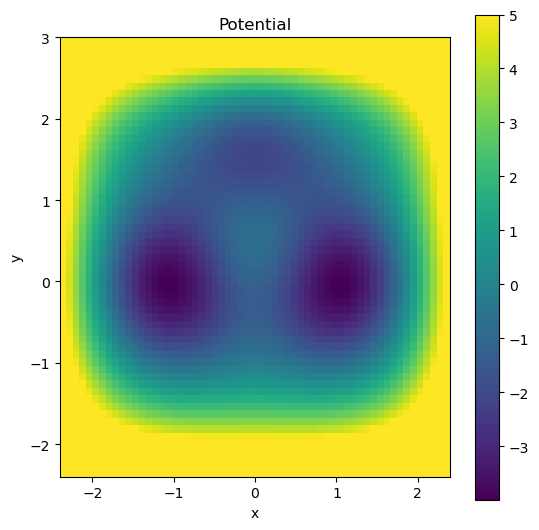

In [2]:
# Potential energy function
def V(x, y):
    #return (x**2 - 1)**2 + 0.5*y * x + y**2     # kJ mol-1
    return 3 * np.exp(-x ** 2 - (y - 1/3) ** 2) \
    - 3 * np.exp(-x ** 2 - (y - 5/3) ** 2) \
    - 5 * np.exp(-(x - 1) ** 2 - y ** 2) \
    - 5 * np.exp(-(x + 1) ** 2 - y ** 2) \
    + 0.2 * x ** 4 \
    + 0.2 * (y - 1/3) ** 4

# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
mass  = 1           # amu
gamma = 1           # ps-1

D     = kB * T / mass / gamma # nm2 ps-1
sigma = np.sqrt(2 * D)
beta  = 1 / kB / T

# Grid
nd     =  2  # Number of dimensions
xedges = 60  # x boundaries
xmin   = -2.4
xmax   =  2.4

yedges = 60  # y boundaries
ymin   = -2.4
ymax   =  3


x      = np.linspace(xmin, xmax, xedges)  # array with x edges
dx     = x[1] - x[0]
x      = x[:-1] + (dx / 2)                # array with x centers
xbins  = xedges - 1

y      = np.linspace(ymin, ymax, yedges)  # array with y edges
dy     = y[1] - y[0]
y      = y[:-1] + (dy / 2)                # array with y centers
ybins  = yedges - 1

Nbins  = xbins*ybins                      # number of bins

grid = np.meshgrid(x,y)


fig, ax1 = plt.subplots(1, 1,figsize=(16*in2cm, 16*in2cm))  

pos = ax1.pcolor(grid[0], grid[1], V(grid[0], grid[1]), shading='auto', vmax=5)
ax1.set_title('Potential')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(pos, ax=ax1)

## Create Voronoi tessellation

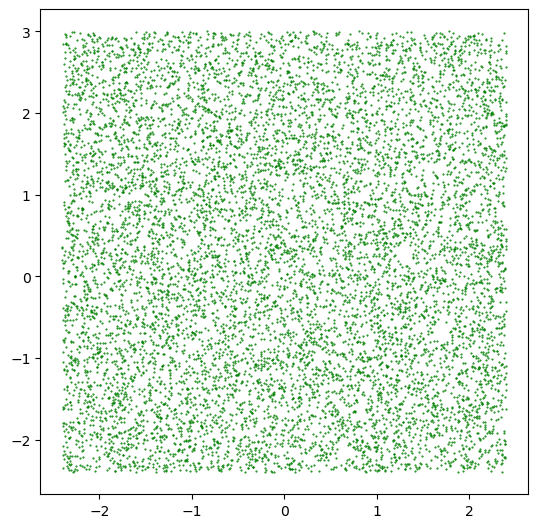

In [3]:
# Number of initial points uniformly distributed
Npoints  = 10000
xpoints  = np.random.uniform(xmin, xmax, Npoints)
ypoints  = np.random.uniform(ymin, ymax, Npoints)
points   = np.array((xpoints, ypoints))

fig, ax = plt.subplots(1, 1,figsize=(16*in2cm, 16*in2cm))  

ax = fig.gca()
ax.plot(points[0], points[1], 'g.',markersize=1)

Text(0, 0.5, 'y')

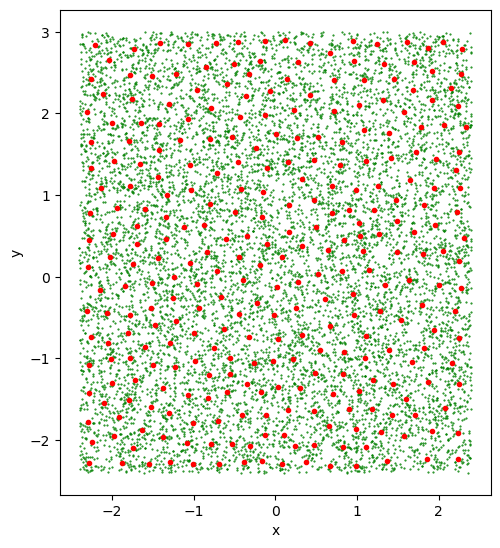

In [4]:
# Number of cluster cells
Ncells  = 300

cells = kmeans(points.T,Ncells,iter=50)
cells = cells[0]
cc_x = cells[:,0]
cc_y = cells[:,1]


# Alternative with Pyemma:
#cells = coor.cluster_kmeans(points, k = Ncells, max_iter = 100)
#cells = cells.clustercenters
#cc_x = cells[:,0]
#cc_y = cells[:,1]

fig, ax = plt.subplots(1, 1,figsize=(16*in2cm, 16*in2cm))  

ax = fig.gca()
ax.plot(points[0], points[1], 'g.',markersize=1)
ax.plot(cc_x, cc_y, 'ro', markersize=3)
ax.set_aspect('equal', 'box')

ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

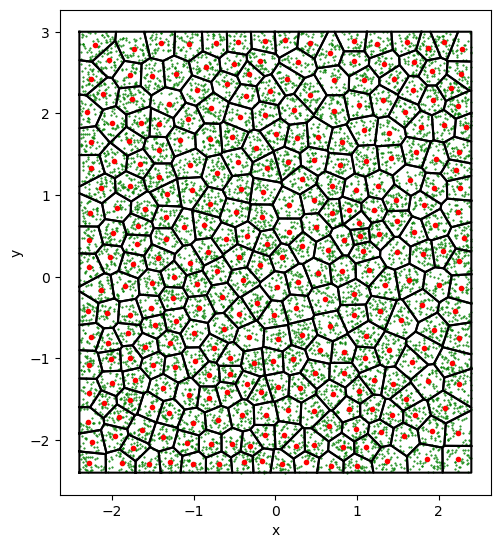

In [5]:
vor = clippedVoronoi.voronoi(cells, (xmin, xmax, ymin, ymax))

xcenters = vor.filtered_points[:,0]
ycenters = vor.filtered_points[:,1]

fig, ax = plt.subplots(1, 1,figsize=(16*in2cm, 16*in2cm))  

ax = fig.gca()
ax.plot(points[0], points[1], 'g.',markersize=1)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax.plot(xcenters[i], ycenters[i], 'ro', markersize=3)
ax.set_aspect('equal', 'box')

ax.set_xlabel('x')
ax.set_ylabel('y')

## Adjaceny matrix

Adjacency matrix is generated searching Voronoi cells sharing the same vertices.
The same script is using to estimate the matrix $\mathcal{S}_{ij}$ with the intersecting surfaces and the matrix $h_{ij}$ distance between adjacent points.

In [15]:
# Volumes    
Vol    = np.zeros(Ncells)

# Adjacency matrix
A      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Intersecting areas
S      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Distances between neighboring points 
h      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Note that len(vor.filtered_regions) = Ncells
# region = Voronoi cell
for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    Vol[i] = ConvexHull(vertices).volume

    for j in range(i+1, Ncells):
        
        #ri and rj contain the vertices of the region omega_i and omega_j
        ri = vor.filtered_regions[i]
        rj = vor.filtered_regions[j]
        int_sur = np.intersect1d(ri, rj)

        # if two cells share vertices, 
        if int_sur.size != 0:
            
            # then they are adjacent:
            A[i,j] = 1
            A[j,i] = 1
            
            # Coordinates of the cells centers
            v0_x       = vor.filtered_points[i,0]
            v0_y       = vor.filtered_points[i,1]
            v1_x       = vor.filtered_points[j,0]
            v1_y       = vor.filtered_points[j,1]
            
            # Distance between the centers
            distance = np.sqrt( (v1_x - v0_x)**2 + (v1_y - v0_y)**2 )
            h[i,j]   = distance
            h[j,i]   = distance
            
            # Coordinates of the intersecting vertices
            int_sur0_x = vor.vertices[int_sur[0],0]
            int_sur0_y = vor.vertices[int_sur[0],1]
            int_sur1_x = vor.vertices[int_sur[1],0]
            int_sur1_y = vor.vertices[int_sur[1],1]
                        
            # Intersecting area (length of the common edge)
            area = np.sqrt( (int_sur1_x - int_sur0_x)**2 + (int_sur1_y - int_sur0_y)**2 )
            S[i,j] = area
            S[j,i] = area
            



## SqRA

$$
\pi(x,y) = \exp(-\beta V(x,y))
$$

$$
Q_{ij} = \frac{\mathcal{S}_{ij}}{\mathcal{V}_i h_{ij}} \sqrt{\frac{\pi_j}{\pi_i}}
$$

In [8]:
# Boltzmann distribution
pi   = np.exp(-beta * V(cc_x, cc_y))
sqra = np.sqrt(pi)

Q = scipy.sparse.lil_matrix((Ncells, Ncells))

for i in range(Ncells):
    for j in range(Ncells):
        if A[i,j] == 1:
            Q[i,j] = S[i,j] / Vol[i] / h[i,j] * sqra[j] / sqra[i]
            
# The diagonal is equal to minus the row-sum
Q    = Q + scipy.sparse.spdiags( - Q.sum(axis=1).T, 0, Ncells, Ncells)
 

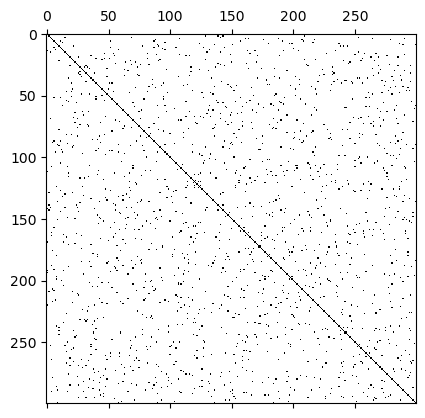

In [39]:
# Q is a sparse matrix
plt.spy(Q.toarray())

## Eigenvalue problem
Estimate left eigenvectors and eigenvalues:

$$
Q \varphi_i(x) = \lambda_i \varphi_i(x)
$$

In [29]:
# Number of eigenvectors
Nevecs = 50

# Eigenvalue problem
evals, evecs = scipy.sparse.linalg.eigs(Q.T, Nevecs, which='LR')
evals = np.real(evals)
evecs = np.real(evecs)
evecs[:,0] = np.abs(evecs[:,0])

e0 = np.real(evecs[:,0])
e1 = np.real(evecs[:,1])
e2 = np.real(evecs[:,2])
e3 = np.real(evecs[:,3])
e4 = np.real(evecs[:,4])
e5 = np.real(evecs[:,5])

Text(0.5, 1.0, 'Eigenvalues')

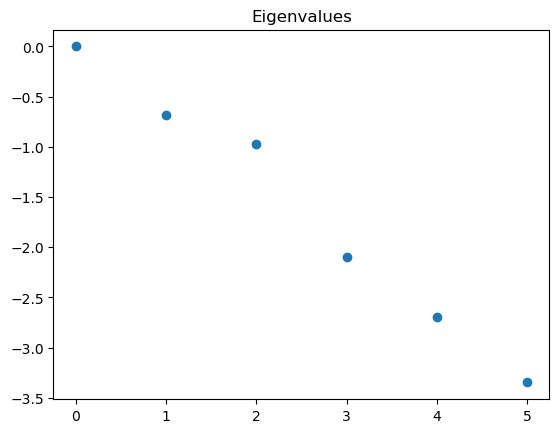

In [11]:
plt.plot(evals[0:6],'o')
plt.title('Eigenvalues')

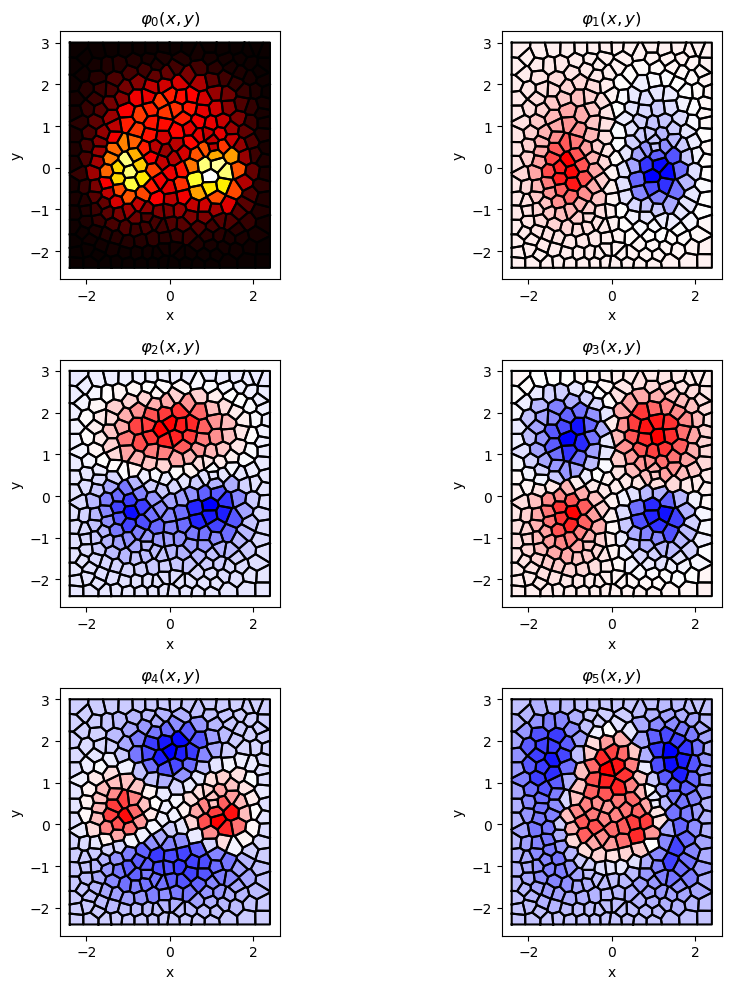

In [35]:
#
# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=np.min(e0), vmax=np.max(e0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)


fig, (ax) = plt.subplots(3, 2, figsize=(10,10))


# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=np.min(e0), vmax=np.max(e0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[0,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[0,0].fill(*zip(*polygon), color=mapper.to_rgba(e0[i]));
    ax[0,0].set_aspect('equal', 'box')
    ax[0,0].set_xlabel('x')
    ax[0,0].set_ylabel('y')
    ax[0,0].set_title(r'$\varphi_0(x,y)$')
    
    
    
norm = mpl.colors.Normalize(vmin=np.min(e1), vmax=np.max(e1), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[0,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[0,1].fill(*zip(*polygon), color=mapper.to_rgba(e1[i]));
    ax[0,1].set_aspect('equal', 'box')
    ax[0,1].set_xlabel('x')
    ax[0,1].set_ylabel('y')
    ax[0,1].set_title(r'$\varphi_1(x,y)$')
    
    
norm = mpl.colors.Normalize(vmin=np.min(e2), vmax=np.max(e2), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[1,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[1,0].fill(*zip(*polygon), color=mapper.to_rgba(e2[i]));
    ax[1,0].set_aspect('equal', 'box')
    ax[1,0].set_xlabel('x')
    ax[1,0].set_ylabel('y')
    ax[1,0].set_title(r'$\varphi_2(x,y)$')
    
norm = mpl.colors.Normalize(vmin=np.min(e3), vmax=np.max(e3), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[1,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[1,1].fill(*zip(*polygon), color=mapper.to_rgba(e3[i]));
    ax[1,1].set_aspect('equal', 'box')
    ax[1,1].set_xlabel('x')
    ax[1,1].set_ylabel('y')
    ax[1,1].set_title(r'$\varphi_3(x,y)$')
    
norm = mpl.colors.Normalize(vmin=np.min(e4), vmax=np.max(e4), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[2,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[2,0].fill(*zip(*polygon), color=mapper.to_rgba(e4[i]));
    ax[2,0].set_aspect('equal', 'box')
    ax[2,0].set_xlabel('x')
    ax[2,0].set_ylabel('y')
    ax[2,0].set_title(r'$\varphi_4(x,y)$')
    
norm = mpl.colors.Normalize(vmin=np.min(e5), vmax=np.max(e5), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[2,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[2,1].fill(*zip(*polygon), color=mapper.to_rgba(e5[i]));
    ax[2,1].set_aspect('equal', 'box')
    ax[2,1].set_xlabel('x')
    ax[2,1].set_ylabel('y')
    ax[2,1].set_title(r'$\varphi_5(x,y)$')
    
fig.tight_layout();

We expand an initial probability 

$$
p(x,0) = \delta(x-x_0) = \sum_{i=0}^{\infty} c_i \varphi_i(x) \, ,
$$

with expansion coefficients

$$
c_i = \langle p_0 \varphi_i(x) \rangle_\pi
$$

In [12]:
p0 = np.zeros(Ncells)

x0 = -1
y0 =  0

# Find the cell which contains (x0, y0):
d  = np.sqrt((xcenters - x0)**2 + (ycenters - y0)**2)
i0 = np.argmin(d)

p0[i0] = 1

c = np.zeros(Nevecs)
for i in range(Nevecs):
    c[i] = np.dot(p0, evecs[:,i] * e0) 

A solution is expressed as

$$
p(x,t) = \sum_{i=0}^{\infty} \exp(\kappa_i t) c_i \varphi_i(x)
$$

In [13]:
dt = 0.1
t0 = 0


t1 = 1 * dt
p1 = np.sum(c * np.exp(evals*t1) * evecs, axis=1)

t2 = 10 * dt
p2 = np.sum(c * np.exp(evals*t2) * evecs, axis=1)

t3 = 20 * dt
p3 = np.sum(c * np.exp(evals*t3) * evecs, axis=1)

t4 = 30 * dt
p4 = np.sum(c * np.exp(evals*t4) * evecs, axis=1)

t5 = 50 * dt
p5 = np.sum(c * np.exp(evals*t5) * evecs, axis=1)

t6 = 500 * dt
p6 = np.sum(c * np.exp(evals*t6) * evecs, axis=1)

C:\Users\donat\AppData\Local\Temp\ipykernel_17792\3659558266.py:116: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mapper)


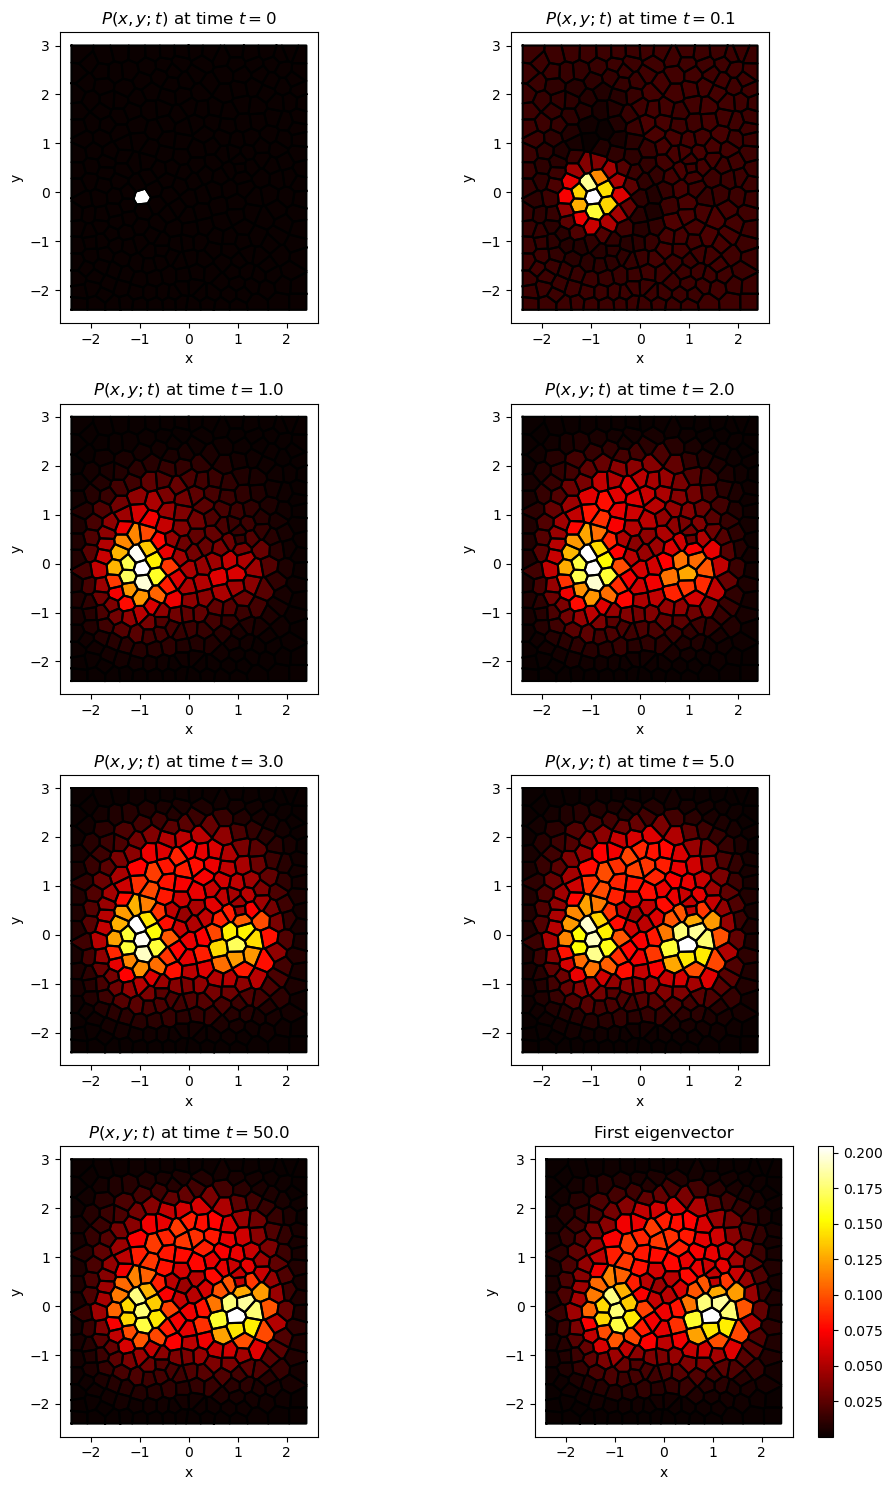

In [37]:
fig, (ax) = plt.subplots(4, 2, figsize=(10,15))


norm = mpl.colors.Normalize(vmin=np.min(p0), vmax=np.max(p0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[0,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[0,0].fill(*zip(*polygon), color=mapper.to_rgba(p0[i]));
    ax[0,0].set_aspect('equal', 'box')
    ax[0,0].set_xlabel('x')
    ax[0,0].set_ylabel('y')
    ax[0,0].set_title(r'$P(x,y;t)$ at time $t = $'+str(t0))
    
    
norm = mpl.colors.Normalize(vmin=np.min(p1), vmax=np.max(p1), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[0,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[0,1].fill(*zip(*polygon), color=mapper.to_rgba(p1[i]));
    ax[0,1].set_aspect('equal', 'box')
    ax[0,1].set_xlabel('x')
    ax[0,1].set_ylabel('y')
    ax[0,1].set_title(r'$P(x,y;t)$ at time $t = $'+str(t1))
    
    
norm = mpl.colors.Normalize(vmin=np.min(p2), vmax=np.max(p2), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)
    
for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[1,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[1,0].fill(*zip(*polygon), color=mapper.to_rgba(p2[i]));
    ax[1,0].set_aspect('equal', 'box')
    ax[1,0].set_xlabel('x')
    ax[1,0].set_ylabel('y')
    ax[1,0].set_title(r'$P(x,y;t)$ at time $t = $'+str(t2))
    
    
norm = mpl.colors.Normalize(vmin=np.min(p3), vmax=np.max(p3), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[1,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[1,1].fill(*zip(*polygon), color=mapper.to_rgba(p3[i]));
    ax[1,1].set_aspect('equal', 'box')
    ax[1,1].set_xlabel('x')
    ax[1,1].set_ylabel('y')
    ax[1,1].set_title(r'$P(x,y;t)$ at time $t = $'+str(t3))
    
    
norm = mpl.colors.Normalize(vmin=np.min(p4), vmax=np.max(p4), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[2,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[2,0].fill(*zip(*polygon), color=mapper.to_rgba(p4[i]));
    ax[2,0].set_aspect('equal', 'box')
    ax[2,0].set_xlabel('x')
    ax[2,0].set_ylabel('y')
    ax[2,0].set_title(r'$P(x,y;t)$ at time $t = $'+str(t4))
    

norm = mpl.colors.Normalize(vmin=np.min(p5), vmax=np.max(p5), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[2,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[2,1].fill(*zip(*polygon), color=mapper.to_rgba(p5[i]));
    ax[2,1].set_aspect('equal', 'box')
    ax[2,1].set_xlabel('x')
    ax[2,1].set_ylabel('y')
    ax[2,1].set_title(r'$P(x,y;t)$ at time $t = $'+str(t5))
    
norm = mpl.colors.Normalize(vmin=np.min(p6), vmax=np.max(p6), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[3,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[3,0].fill(*zip(*polygon), color=mapper.to_rgba(p6[i]));
    ax[3,0].set_aspect('equal', 'box')
    ax[3,0].set_xlabel('x')
    ax[3,0].set_ylabel('y')
    ax[3,0].set_title(r'$P(x,y;t)$ at time $t = $'+str(t6))
    

norm = mpl.colors.Normalize(vmin=np.min(e0), vmax=np.max(e0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[3,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[3,1].fill(*zip(*polygon), color=mapper.to_rgba(e0[i]));
    ax[3,1].set_aspect('equal', 'box')
    ax[3,1].set_xlabel('x')
    ax[3,1].set_ylabel('y')
    ax[3,1].set_title('First eigenvector')
    
    
#plt.colorbar(mapper)
cbar = fig.colorbar(mapper)

fig.tight_layout();